In [62]:
import pennylane as qml
from pennylane import numpy as np
from qiskit import QuantumCircuit, assemble, Aer
from qiskit.visualization import plot_histogram, plot_bloch_vector, array_to_latex, plot_bloch_multivector
from math import sqrt, pi
from IPython.display import display, Math
import qiskit.quantum_info as qi
import matplotlib

In [63]:
dev1 = qml.device("default.qubit", wires=2)

In [65]:

vec = np.array([1/np.sqrt(2),1/np.sqrt(2)])

In [67]:
@qml.qnode(dev1)
def circuit(params):
    qml.Hadamard(wires=0)
    qml.Hadamard(wires=1) # To make the Rz gate more meaningful, otherwise, if it started with a |0>, it would just be a uninportant global phase
    op1 = qml.RZ(params[0], wires=1)
    op2 = qml.RY(params[1], wires=1)
    op3 = qml.RZ(params[2], wires=1)
    global vec  
    vec = qml.matrix(op3)@qml.matrix(op2)@qml.matrix(op1)@np.transpose(np.array([1/np.sqrt(2),1/np.sqrt(2)]))
    qml.RZ(0.25, wires=0)
    qml.RY(0.5, wires=0)
    qml.RZ(1, wires=0)
    qml.CNOT(wires=[0,1])
    qml.Hadamard(wires=0)
    return qml.probs(wires=[0, 1])

In [68]:
print(circuit([0.25,0.5,1]))

[1.39449847e-01 3.92109953e-01 4.68440199e-01 1.73333695e-33]


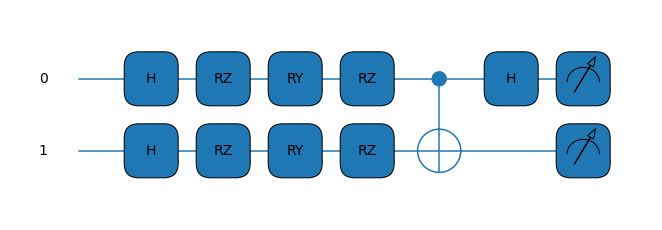

In [69]:
import matplotlib.pyplot as plt
fig, ax = qml.draw_mpl(circuit)([0.25,0.5,1])
plt.show()

In [72]:
print(vec)

[0.36506586-0.30005551j 0.75000367+0.4628046j ]


In [70]:
def cost(x):
    return circuit(x)[3]

In [75]:
init_params = np.array([0.15,0.8,0.7], requires_grad=True)
print(cost(init_params))


0.02210337573217689


Cost after step     5:  0.0061927
Cost after step    10:  0.0020083
Cost after step    15:  0.0007331
Cost after step    20:  0.0002849
Cost after step    25:  0.0001138
Cost after step    30:  0.0000460
Cost after step    35:  0.0000187
Cost after step    40:  0.0000076
Cost after step    45:  0.0000031
Cost after step    50:  0.0000013
Cost after step    55:  0.0000005
Cost after step    60:  0.0000002
Cost after step    65:  0.0000001
Cost after step    70:  0.0000000
Cost after step    75:  0.0000000
Cost after step    80:  0.0000000
Cost after step    85:  0.0000000
Cost after step    90:  0.0000000
Cost after step    95:  0.0000000
Cost after step   100:  0.0000000


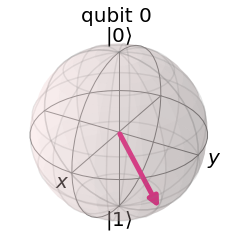

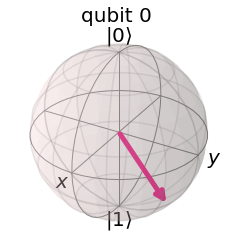

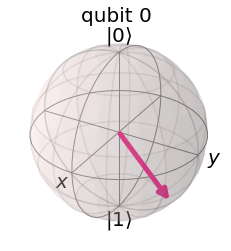

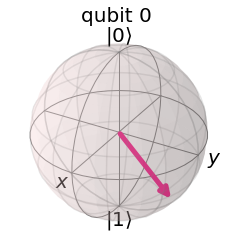

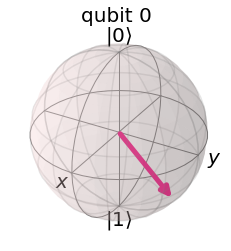

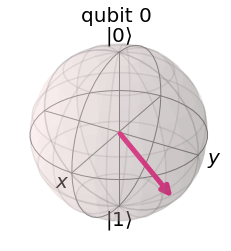

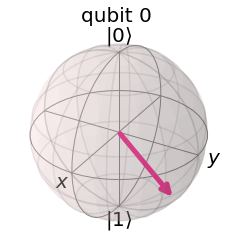

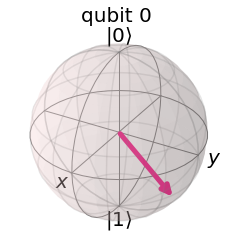

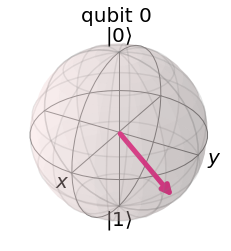

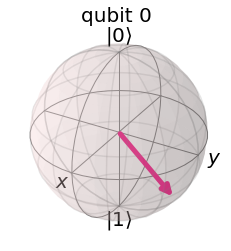

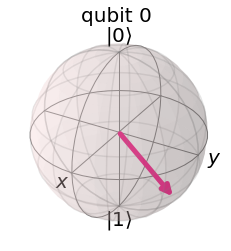

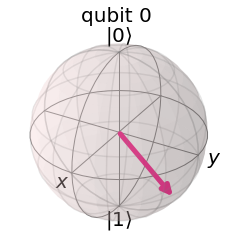

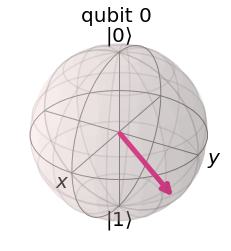

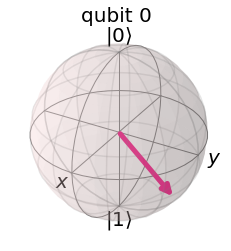

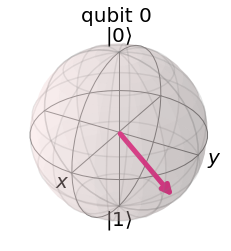

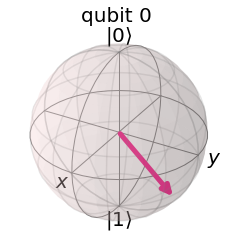

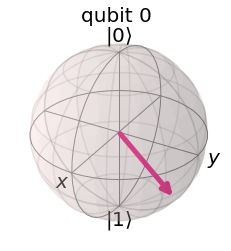

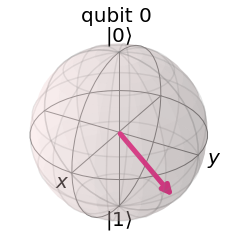

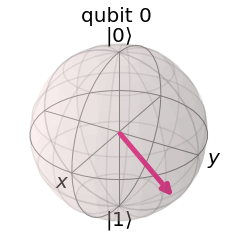

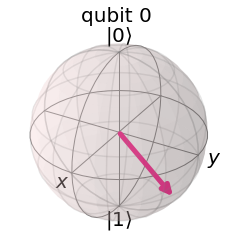

In [76]:
# initialise the optimizer
opt = qml.GradientDescentOptimizer(stepsize=0.4)

# set the number of steps
steps = 100
# set the initial parameter values
params = init_params

for i in range(steps):
    # update the circuit parameters
    params = opt.step(cost, params)
    # print(vec)

    if (i + 1) % 5 == 0:
        print("Cost after step {:5d}: {: .7f}".format(i + 1, cost(params)))
        matplotlib.pyplot.figure(plot_bloch_multivector(vec))

In [9]:
print("Optimized rotation angles: {}".format(params))

Optimized rotation angles: [0.23470587 0.49794458 1.017417  ]


We need 2 qubits, if we just want to make the final state $U|0 \rangle$, but however, to find the exact gate $U$, we can use two basis vectors and use two more qubits. So 2 or 4 qubits would do, although 4 would give you a better gate for $U$. (The other two would look at the action of $U$ on $|1 \rangle$. 

We need to learn 3 parameters, the three angles.

The loss function is just to minimise the probability that the measured state is $|11 \rangle$. If I was taking into account 4 qubits, I would have a different loss function, involving the probabilities of measuring $|11 \rangle$ from both sets of two qubits. It would probably be

$$2 - \sqrt{1 - 2*\text{prob}_1(11)} - \sqrt{1 - 2*\text{prob}_2(11)}$$

Where the subscripts 1 and 2 denote the different sets of two qubits that I would use while using 4 qubits.

In [25]:
dev2 = qml.device("default.qubit", wires=2)
op1 = qml.RZ(params[0], wires=1)
op2 = qml.RY(params[1], wires=1)
op3 = qml.RZ(params[2], wires=1)
op4 = qml.RZ(0.25, wires=0)
op5 = qml.RY(0.5, wires=0)
op6 = qml.RZ(1, wires=0)
a = qml.matrix(op1)
b = qml.matrix(op2)
c = qml.matrix(op3)
d = qml.matrix(op4)
e = qml.matrix(op5)
f = qml.matrix(op6)
mat1 = a@b@c
mat2 = d@e@f
mat3 = (mat2 - mat1)**2
out1 = np.sqrt(np.sum(mat3))
print(out1)

0.0035394730826559325j
